In [1]:
import numpy as np
import pandas as pd
import anndata
import scprep
import scanpy as sc
import sklearn
from sklearn.model_selection import train_test_split
import tempfile
import os
import inspect
import sys
import scipy
from scipy import sparse

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

from pathlib import Path
import umap

import matplotlib.pyplot as plt

In [60]:
torch.cuda.is_available()

True

# Table of Contents
1. Baselines
    1. [Procrustes Baseline](#procrustes-baseline)
    2. [Harmonic Alignment Baseline](#harmonic-alignment-baseline)

# **try out with scicar cell lines dataset**

**1. URLs for raw data**

In [2]:
rna_url = ("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3271040"
    "&format=file&file=GSM3271040%5FRNA%5FsciCAR%5FA549%5Fgene%5Fcount.txt.gz")
rna_cells_url = (
    "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3271040"
    "&format=file&file=GSM3271040%5FRNA%5FsciCAR%5FA549%5Fcell.txt.gz"
)
rna_genes_url = (
    "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3271040"
    "&format=file&file=GSM3271040%5FRNA%5FsciCAR%5FA549%5Fgene.txt.gz"
)
atac_url = (
    "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3271041"
    "&format=file&file=GSM3271041%5FATAC%5FsciCAR%5FA549%5Fpeak%5Fcount.txt.gz"
)
atac_cells_url = (
    "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3271041"
    "&format=file&file=GSM3271041%5FATAC%5FsciCAR%5FA549%5Fcell.txt.gz"
)
atac_genes_url = (
    "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3271041"
    "&format=file&file=GSM3271041%5FATAC%5FsciCAR%5FA549%5Fpeak.txt.gz"
)

In [3]:
rna_genes = pd.read_csv(rna_genes_url, index_col=0)
atac_genes =  pd.read_csv(atac_genes_url, index_col=1)
rna_cells = pd.read_csv(rna_cells_url, index_col=0)
atac_cells = pd.read_csv(atac_cells_url, index_col=0)

/home/shahula/bin/miniconda3/envs/multimodal/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
data_directory = Path("data")
rna_file = str(data_directory / "rna.mtx.gz")
atac_file = str(data_directory / "atac.mtx.gz")

try:
    data_directory.mkdir()
    scprep.io.download.download_url(rna_url, rna_file)
    scprep.io.download.download_url(atac_url, atac_file)
except FileExistsError:
    print("Data already on disk.")
    
rna_data = scprep.io.load_mtx(rna_file, cell_axis="col").tocsr()
atac_data = scprep.io.load_mtx(atac_file, cell_axis="col").tocsr()

Data already on disk.


 **2. select the joint sub-datasets and store them into csv files**

In [5]:
def create_joint_dataset(X, Y, X_index=None, X_columns=None, Y_index=None, Y_columns=None):
    if X_index is None:
        X_index = X.index
    if X_columns is None:
        X_columns = X.columns
    if Y_index is None:
        Y_index = Y.index
    if Y_columns is None:
        Y_columns = Y.columns
    joint_index = np.sort(np.intersect1d(X_index, Y_index))
    try:
        X = X.loc[joint_index]
        Y = Y.loc[joint_index]
    except AttributeError:
        x_keep_idx = np.isin(X_index, joint_index)
        y_keep_idx = np.isin(Y_index, joint_index)
        X = X[x_keep_idx]
        Y = Y[y_keep_idx]
        X_index_sub = scprep.utils.toarray(X_index[x_keep_idx])
        Y_index_sub = scprep.utils.toarray(Y_index[y_keep_idx])
        X = X[np.argsort(X_index_sub)]
        Y = Y[np.argsort(Y_index_sub)]
        # check order is correct
        assert (X_index_sub[np.argsort(X_index_sub)] == joint_index).all()
        assert (Y_index_sub[np.argsort(Y_index_sub)] == joint_index).all()
    adata = anndata.AnnData(
        scprep.utils.to_array_or_spmatrix(X).tocsr(),
        obs = pd.DataFrame(index = joint_index),
        var = pd.DataFrame(index = X_columns),
    )
    adata.obsm["mode2"] = scprep.utils.to_array_or_spmatrix(Y).tocsr()
    adata.uns["mode2_obs"] = joint_index
    adata.uns["mode2_var"] = scprep.utils.toarray(Y_columns)
    
    return adata, joint_index

In [6]:
def subset_mode2_genes(adata, keep_genes):
    adata.obsm["mode2"] = adata.obsm["mode2"][:, keep_genes]
    adata.uns["mode2_var"] = adata.uns["mode2_var"][keep_genes]
    if "mode2_varnames" in adata.uns:
        for varname in adata.uns["mode2_varnames"]:
            adata.uns[varname] = adata.uns[varname][keep_genes]
            
    return adata

In [7]:
def filter_joint_data_empty_cells(adata):
    assert np.all(adata.uns["mode2_obs"] == adata.obs.index)
    #filter out cells
    n_cells_mode1 = scprep.utils.toarray(adata.X.sum(axis = 1)).flatten()
    n_cells_mode2 = scprep.utils.toarray(adata.obsm["mode2"].sum(axis = 1)).flatten()
    keep_cells = np.minimum(n_cells_mode1, n_cells_mode2) > 1
    adata.uns["mode2_obs"] = adata.uns["mode2_obs"][keep_cells]
    adata = adata[keep_cells, :].copy()
    #filter out genes
    sc.pp.filter_genes(adata, min_counts=1)
    n_genes_mode2 = scprep.utils.toarray(adata.obsm["mode2"].sum(axis=0)).flatten()
    keep_genes_mode2 = n_genes_mode2 > 0
    adata = subset_mode2_genes(adata, keep_genes_mode2)
    
    return adata, keep_cells

In [8]:
def merge_data(rna_data, atac_data, rna_cells, atac_cells, rna_genes, atac_genes):
    scicar_data, joint_index = create_joint_dataset(
        rna_data, atac_data, 
        X_index=rna_cells.index, 
        X_columns=rna_genes.index, 
        Y_index=atac_cells.index,
        Y_columns=atac_genes.index
    )

    scicar_data.obs = rna_cells.loc[scicar_data.obs.index]
    scicar_data.var = rna_genes
    for key in atac_cells.columns:
        scicar_data.obs[key] = atac_cells[key]
    scicar_data.uns["mode2_varnames"] = []
    for key in atac_genes.columns:
        varname = "mode2_var_{}".format(key)
        scicar_data.uns[varname] = atac_genes[key].values
        scicar_data.uns["mode2_varnames"].append(varname)
    scicar_data, keep_cells_idx = filter_joint_data_empty_cells(scicar_data)
    return scicar_data, joint_index, keep_cells_idx

In [9]:
def subset_joint_data(adata, n_cells=600, n_genes=1500):
    if adata.shape[0] > n_cells:
        keep_cells = np.random.choice(adata.shape[0], n_cells, replace=False)
        adata = adata[keep_cells].copy()
        adata.uns["mode2_obs"] = adata.uns["mode2_obs"][keep_cells]
        adata, _ = filter_joint_data_empty_cells(adata)

    if adata.shape[1] > n_genes:
        keep_mode1_genes = np.random.choice(adata.shape[1], n_genes, replace=False)
        adata = adata[:, keep_mode1_genes].copy()

    if adata.obsm["mode2"].shape[1] > n_genes:
        keep_genes_mode2 = np.random.choice(
            adata.obsm["mode2"].shape[1], n_genes, replace=False
        )
        adata = subset_mode2_genes(adata, keep_genes_mode2)
        
    adata, _ = filter_joint_data_empty_cells(adata)
    
    return adata

In [10]:
scicar_data, joint_index, keep_cells_idx = merge_data(rna_data, atac_data, rna_cells, atac_cells, rna_genes, atac_genes)
#rna_df, atac_df = ann2df(scicar_data)

In [11]:
print(scicar_data)

AnnData object with n_obs × n_vars = 4739 × 60550
    obs: 'cell_name', 'experiment', 'treatment_time', 'source', 'group'
    var: 'gene_type', 'gene_short_name', 'n_counts'
    uns: 'mode2_obs', 'mode2_var', 'mode2_varnames', 'mode2_var_id', 'mode2_var_chr', 'mode2_var_start', 'mode2_var_end'
    obsm: 'mode2'


In [12]:
test_scicar_data = subset_joint_data(scicar_data)

# **logcpm, sqrtcpm**

In [13]:
import functools
def normalizer(func, *args, **kwargs):
    @functools.wraps(func)
    def normalize(adata, *args, obsm=None, obs=None, var=None, **kwargs):
        if obsm is not None:
            cache_name = "{}_{}".format(obsm, func.__name__)
            if cache_name in adata.obsm:
                adata.obsm[obsm] = adata.obsm[cache_name]
            else:
                name_obs = obs
                name_var = var
                obs = adata.uns[obs] if obs else adata.obs
                var = adata.uns[var] if var else adata.var
                adata_temp = anndata.AnnData(adata.obsm[obsm], obs = obs, var = var)
                func(adata_temp, *args, **kwargs)
                adata.obsm[obsm] = adata.obsm[cache_name] = adata_temp.X
                adata.uns[name_var] = adata_temp.var
                adata.uns[name_obs] = adata_temp.obs
        else:
            if func.__name__ in adata.layers:
                adata.X = adata.layers[func.__name__]
            else:
                func(adata, *args, **kwargs)
                adata.layers[func.__name__] = adata.X
            
    return normalize

In [14]:
def _cpm(adata):
    adata.layers["count"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum = 1e6, key_added = "size_factors")

In [15]:
@normalizer
def log_cpm(adata):
    _cpm(adata)
    sc.pp.log1p(adata)
  
@normalizer
def sqrt_cpm(adata):
    _cpm(adata)
    adata.X = scprep.transform.sqrt(adata.X)

In [16]:
@normalizer
def hvg_by_sc(adata, proportion = .1):
    n_genes = len(adata.var)
    n_genes_to_keep = int(n_genes*proportion)
    sc.pp.highly_variable_genes(adata, n_top_genes = n_genes_to_keep, subset=True)

# **convert R function and run logscran**

In [17]:
def r_function(filename):
    curr_frame = inspect.currentframe()
    prev_frame = inspect.getframeinfo(curr_frame.f_back)
    filepath = os.path.join(os.path.dirname(prev_frame.filename), filename)
    print(filepath)
    with open(filepath, "r") as handle:
        r_code = handle.read()
    out_func = scprep.run.RFunction(setup="", args="sce", body=r_code)
    out_func.__r_file__ = filepath
    
    return out_func

In [18]:
#scran normalization funciton
_scran = scprep.run.RFunction(
    setup="library('scran')",
    args="sce, min.mean=0.1",
    body="""
    sce <- computeSumFactors(sce, min.mean=min.mean, assay.type="X")
    sizeFactors(sce)
    """,
)

In [19]:
#log scran pooling
#dividing all counts for each cell by a cell-specific scaling factor(size factor)
#assumption:any cell-specific bias (e.g.,  amplification efficiency) affects all genes equally 
#via scaling of the expected mean count for that cell
@normalizer
def log_scran_pooling(adata):
    scprep.run.install_bioconductor("scran")
    adata.obs["size_factor"] = _scran(adata)

    #why here is multiplication instead of division
    adata.X = scprep.utils.matrix_vector_elementwise_multiply(
        adata.X, adata.obs["size_factor"], axis = 0
    )
    sc.pp.log1p(adata)

# **Metrics**

In [20]:
#KNN-AUC
def knn_auc(adata, proportion_neighbors=0.1, n_svd=100):
    n_svd = min([n_svd, min(adata.X.shape)-1])
    n_neighbors = int(np.ceil(proportion_neighbors*adata.X.shape[0]))
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(adata.X)
    _, indices_true = (
        sklearn.neighbors.NearestNeighbors(n_neighbors = n_neighbors).fit(X_pca).kneighbors(X_pca)
    )
    _, indices_pred = (
        sklearn.neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(adata.obsm["aligned"]).kneighbors(adata.obsm["mode2_aligned"])
    )
    neighbors_match = np.zeros(n_neighbors, dtype=int)
    for i in range(adata.shape[0]):
        _, pred_matches, true_matches = np.intersect1d(
            indices_pred[i], indices_true[i], return_indices=True
        )
        neighbors_match_idx = np.maximum(pred_matches, true_matches)
        neighbors_match += np.sum(np.arange(n_neighbors) >= neighbors_match_idx[:, None], axis = 0,)
        neighbors_match_curve = neighbors_match/(np.arange(1, n_neighbors + 1) * adata.shape[0])
        area_under_curve = np.mean(neighbors_match_curve)
        
    return area_under_curve

In [21]:
#MSE
def _square(X):
    if sparse.issparse(X):
        X.data = X.data ** 2
        return X
    else:
        return scprep.utils.toarray(X) ** 2

def mse(adata):
    X=scprep.utils.toarray(adata.obsm["aligned"])
    Y=scprep.utils.toarray(adata.obsm["mode2_aligned"])

    X_shuffled = X[np.random.permutation(np.arange(X.shape[0])), :]
    error_random = np.mean(np.sum(_square(X_shuffled - Y)))
    error_abs = np.mean(np.sum(_square(X - Y)))
    return error_abs/error_random

In [35]:
def plot_multimodal_umap(adata, num_points=None, connect_modalities=False):
    X=scprep.utils.toarray(adata.obsm["aligned"][:num_points])
    Y=scprep.utils.toarray(adata.obsm["mode2_aligned"][:num_points])
    
    sizes = np.sum(_square(X - Y), axis=1)
    
    sizes = 100 * sizes / sizes.max() + 1
    reduced_data = umap.UMAP().fit_transform(np.vstack([X, Y]))[:, :2]
    X_reduced, Y_reduced = reduced_data[:len(X)], reduced_data[len(X):]

    plt.figure(figsize=(8, 6), dpi=80)
        
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], s=sizes, alpha=0.5)
    plt.scatter(Y_reduced[:, 0], Y_reduced[:, 1], s=sizes, alpha=0.5)
    if connect_modalities:
        x_coordinates = reduced_data[:, 0].reshape((2, len(X)))
        y_coordinates = reduced_data[:, 1].reshape((2, len(X)))
        plt.plot(x_coordinates, y_coordinates, '--', c="green", alpha=0.25)

    plt.show()
#     for index, (x, y) in enumerate(zip(X_reduced, Y_reduced)):
#         plt.scatter(x[0], x[1], c="red", s=sizes[index])
#         plt.scatter(y[0], y[1], c="blue", s=sizes[index])

<a name="procrustes-baseline"></a>
## Procrustes Baseline

In [23]:
def procrustes(adata, n_svd=100):
    n_svd = min([n_svd, min(adata.X.shape)-1, min(adata.obsm["mode2"].shape)-1])
    log_cpm(adata)
    log_cpm(adata, obsm="mode2", obs="mode2_obs", var="mode2_var")
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(adata.X)
    Y_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(adata.obsm["mode2"])
    X_proc, Y_proc, _ = scipy.spatial.procrustes(X_pca, Y_pca)
    adata.obsm["aligned"] = X_proc
    adata.obsm["mode2_aligned"] = Y_proc
    
    return adata

In [43]:
def plot_procrustes_knn(params_range):
    test_scicar_data = subset_joint_data(scicar_data)
    knn_scores = [0.0] * len(params_range)
    for i, n_svd in enumerate(params_range):
        test_scicar = test_scicar_data.copy()
        procrustes(test_scicar, n_svd = n_svd)
        knn_score = knn_auc(test_scicar, n_svd = n_svd)
        knn_scores[i] = knn_score
    plt.xlabel("n_svd")
    plt.ylabel("knn score")
    plt.plot(params_range, knn_scores)
    plt.show()

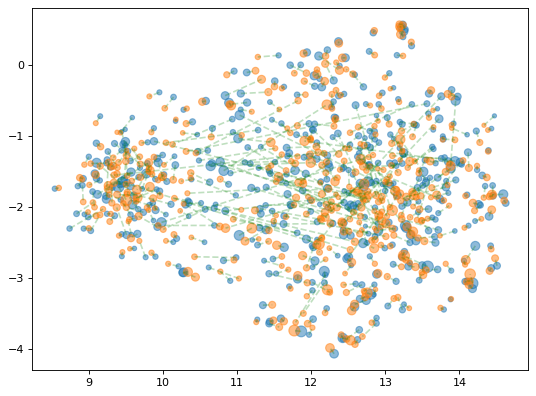

In [57]:
random_subset_scicar_data = subset_joint_data(scicar_data)
train_scicar_data, test_scicar_data = split_test_train(random_subset_scicar_data)
procrustes_model = procrustes(train_scicar_data, n_svd = 400)
knn_auc(train_scicar_data, n_svd=400)

plot_multimodal_umap(train_scicar_data, connect_modalities=True)

In [ ]:
procrustes_model.fit(test_scicar_data)
print(knn_auc(test_scicar_data, n_svd=400))

plot_multimodal_umap(test_scicar_data, connect_modalities=True)

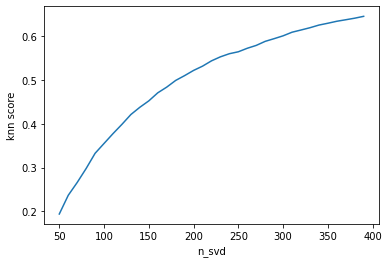

In [45]:
plot_procrustes_knn(range(50, 400, 10))

0.3567702482316367
0.7387614397380222


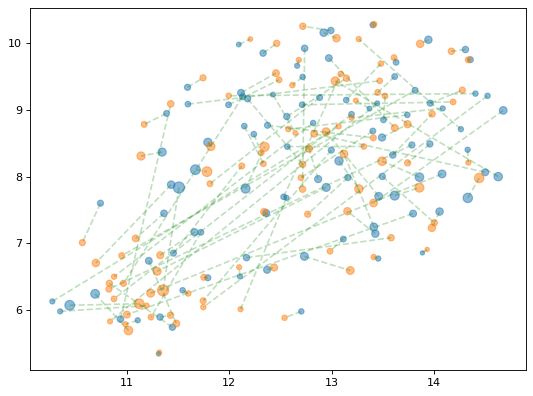

In [51]:
#alignment score when using 100 as hidden dimension
procrustes(test_scicar_data)
print(knn_auc(test_scicar_data))
print(mse(test_scicar_data))

plot_multimodal_umap(test_scicar_data, num_points=100, connect_modalities=True)

<a name="harmonic-alignment-baseline"></a>
## Harmonic Alignment Baseline

In [52]:
# See https://github.com/KrishnaswamyLab/harmonic-alignment/tree/master/python
import harmonicalignment

In [53]:
#sqrt CPM version

def harmonic_alignment_sqrt_cpm(adata, n_eigenvectors=100, n_svd=100, n_pca_XY=100):
    sqrt_cpm(adata)
    log_cpm(adata)
    n_svd = min([n_svd, min(adata.X.shape)-1, min(adata.obsm["mode2"].shape)-1])
    if adata.X.shape[0] <= n_eigenvectors:
        n_eigenvectors = None
    if adata.X.shape[0] <= n_pca_XY:
        n_pca_XY = None
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(adata.X)
    Y_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(adata.obsm["mode2"])
    ha_op = harmonicalignment.HarmonicAlignment(
        n_filters=8, n_pca_XY=n_pca_XY, n_eigenvectors=n_eigenvectors
    )
    ha_op.align(X_pca, Y_pca)
    XY_aligned = ha_op.diffusion_map(n_eigenvectors=n_eigenvectors)
    adata.obsm["aligned"] = XY_aligned[: X_pca.shape[0]]
    adata.obsm["mode2_aligned"] = XY_aligned[X_pca.shape[0] :]
    return adata

/home/shahula/.local/lib/python3.8/site-packages/graphtools/graphs.py:287: RuntimeWarning: Detected zero distance between 11 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


0.06771126315878696
1.0028490638831444


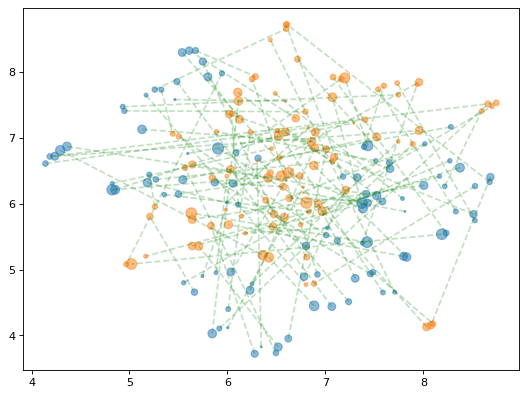

In [54]:
test_scicar_data = subset_joint_data(scicar_data)
harmonic_alignment_sqrt_cpm(test_scicar_data)
print(knn_auc(test_scicar_data))
print(mse(test_scicar_data))

plot_multimodal_umap(test_scicar_data, num_points=100, connect_modalities=True)


## Scot Alignment Baseline

In [35]:
!git clone https://github.com/rsinghlab/SCOT.git

fatal: destination path 'SCOT' already exists and is not an empty directory.


In [41]:
!pip install POT
!pip install matlab
!pip install cython

     |████████████████████████████████| 440kB 5.4MB/s 


In [44]:
sys.path.insert(1, "./SCOT/src")
import scot2
from scot2 import SCOT

In [58]:
def _scot(adata, n_svd=100, balanced=False):
    n_svd = min(n_svd, min(adata.X.shape)-1, min(adata.obsm["mode2"].shape)-1)
    X_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(adata.X)
    Y_pca = sklearn.decomposition.TruncatedSVD(n_svd).fit_transform(adata.obsm["mode2"])

    scot_new = SCOT(X_pca, Y_pca)
    x_new_unbal, y_new_unbal = scot_new.align(
        k=50, e=1e-3, rho=0.0005, normalize=True, balanced=balanced
    )
    adata.obsm["aligned"] = np.array(x_new_unbal).squeeze()
    adata.obsm["mode2_aligned"] = np.array(y_new_unbal).squeeze()
    return adata

In [59]:
#unbalanced method produces NaN for some reasons
def scot_sqrt_cpm_unbalanced(adata, n_svd=100, balanced=False):
    sqrt_cpm(adata)
    log_cpm(adata, obsm="mode2", obs="mode2_obs", var="mode2_var")
    _scot(adata, n_svd=n_svd, balanced=balanced)
    
    return adata

def scot_sqrt_cpm_balanced(adata, n_svd=100, balanced=True):
    sqrt_cpm(adata)
    log_cpm(adata, obsm="mode2", obs="mode2_obs", var="mode2_var")
    _scot(adata, n_svd=n_svd, balanced=balanced)
    
    return adata

# **Store Scicar Dataset to h5ad File**

In [39]:
scicar_data.write_h5ad(str(data_directory / "scicar_data.h5ad"))

/home/shahula/bin/miniconda3/envs/multimodal/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_name' as categorical
/home/shahula/bin/miniconda3/envs/multimodal/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'experiment' as categorical
/home/shahula/bin/miniconda3/envs/multimodal/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_ca

TypeError: Can't implicitly convert non-string objects to strings

Above error raised while writing key 'uns/mode2_var_chr' of <class 'h5py._hl.files.File'> from /.

# **MNN**

In [ ]:
#convert R function to a collable py function
_mnn = r_function("/gdrive/My Drive/mnn.R")
#mnn with log_cpm preprocessing

def mnn_log_cpm(adata):
  log_cpm(adata)
  log_cpm(adata, obsm="mode2", obs="mode2_obs", var="mode2_var")
  return _mnn(adata)
  
#mnn with log_scran preprocessing
def mnn_log_scran_pooling(adata):
  log_scran_pooling(adata)
  log_cpm(adta, obsm="mode2", obs="mode2_obs", var="mode2_var")
  return _mnn(adata)

/gdrive/My Drive/mnn.R


In [ ]:
%%capture
test_scicar_data = subset_joint_data(scicar_data)
test_scicar_data = mnn_log_scran_pooling(test_scicar_data)
#knn_auc(test_scicar_data)

R[write to console]: Loading required package: BiocManager
R[write to console]: Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)
R[write to console]: Loading required package: scran
R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com
R[write to console]: Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)
R[write to console]: Installing package(s) 'BiocVersion', 'scran'
R[write to console]: also installing the dependencies ‘XVector’, ‘RCurl’, ‘lambda.r’, ‘GenomicRanges’, ‘MatrixGenerics’, ‘Biobase’, ‘IRanges’, ‘GenomeInfoDb’, ‘futile.logger’, ‘matrixStats’, ‘sparseMatrixStats’, ‘ScaledMatrix’, ‘irlba’, ‘rsvd’, ‘BiocNeighbors’, ‘sitmo’, ‘SingleCellExperiment’, ‘scuttle’, ‘SummarizedExperiment’, ‘S4Vectors’, ‘BiocGenerics’, ‘BiocParallel’, ‘edgeR’, ‘limma’, ‘igraph’, ‘statmod’, ‘DelayedArray’, ‘DelayedMatrixStats’, ‘BiocSi

RRuntimeError: ignored

# **alignment score for scot**

In [68]:
test_scicar_data = subset_joint_data(scicar_data)
scot_sqrt_cpm_balanced(test_scicar_data)
print(knn_auc(test_scicar_data))
print(mse(test_scicar_data))

It.  |Err         
-------------------
    0|1.963694e-03|
   10|3.083303e-03|
   20|2.974509e-03|
   30|1.688391e-03|
   40|1.171969e-03|
   50|5.114249e-04|
   60|5.113359e-04|
   70|4.086603e-04|
   80|4.126100e-04|
   90|5.549208e-04|
  100|2.607456e-04|
  110|3.051702e-04|
  120|2.449237e-04|
  130|1.332487e-04|
  140|2.287277e-04|
  150|1.501480e-04|
  160|1.151915e-04|
  170|1.979953e-04|
  180|1.309522e-04|
  190|6.226984e-05|
It.  |Err         
-------------------
  200|6.057074e-05|
  210|7.602713e-05|
  220|6.124313e-05|
  230|3.531016e-05|
  240|3.548595e-05|
  250|6.718757e-05|
  260|1.231954e-04|
  270|2.041685e-04|
  280|1.163106e-04|
  290|3.782405e-04|
  300|2.971809e-04|
  310|4.319390e-04|
  320|7.637726e-05|
  330|3.596583e-05|
  340|1.872889e-05|
  350|1.082439e-05|
  360|7.250256e-06|
  370|5.569596e-06|
  380|4.772585e-06|
  390|4.456574e-06|
It.  |Err         
-------------------
  400|4.467110e-06|
  410|4.766854e-06|
  420|5.394867e-06|
  430|6.466904e-06|
  4